<a href="https://colab.research.google.com/github/PRAVALLIKASALADI/Assignment-1/blob/main/covid_19_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#importing important libraries
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers




In [5]:

# Loading images from Gdrive and creating directory per class
COV_DIR = "/content/drive/MyDrive/archive/COVID_IEEE/covid"
NORM_DIR = "/content/drive/MyDrive/archive/COVID_IEEE/normal"
VIR_DIR = "/content/drive/MyDrive/archive/COVID_IEEE/virus"

In [6]:


# function for printing image specification
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

# function for getting image specification details
def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)


# getting specification of Normal images
Images_details(NORM_DIR)

# getting specification of COVID-19 images
Images_details(COV_DIR)

# getting specification of Viralimages
Images_details(VIR_DIR)

 ====== Images in:  /content/drive/MyDrive/archive/COVID_IEEE/normal
images_count:	92
min_width:	1240
max_width:	2628
min_height:	650
max_height:	2628
 ====== Images in:  /content/drive/MyDrive/archive/COVID_IEEE/covid
images_count:	17
min_width:	1127
max_width:	3520
min_height:	1163
max_height:	4095
 ====== Images in:  /content/drive/MyDrive/archive/COVID_IEEE/virus
images_count:	619
min_width:	384
max_width:	2304
min_height:	127
max_height:	2304


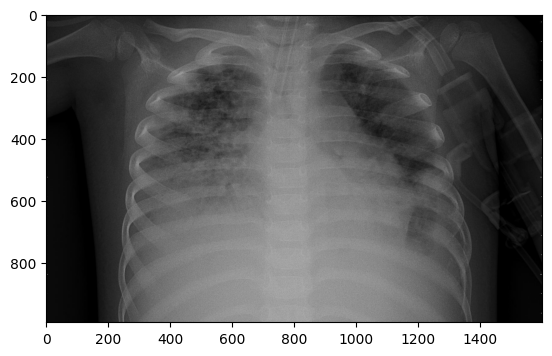

In [7]:
# Loading Original Image
img = cv2.imread('/content/drive/My Drive/archive/COVID_IEEE/virus/person1661_virus_2872.jpeg')
plt.imshow(img, cmap=plt.cm.bone)

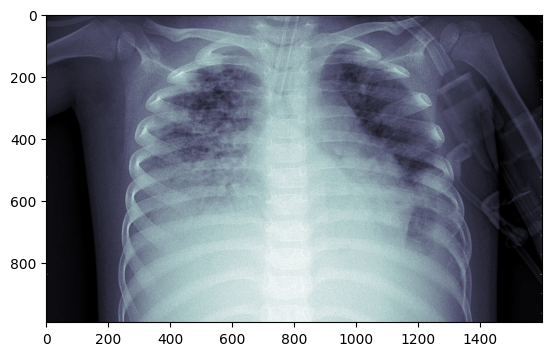

In [8]:
# white balance for every channel independently
def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel


imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(img)] )
# Convert image to grayscale

gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap=plt.cm.bone)

In [9]:
data=[]
labels=[]
Normal=os.listdir("/content/drive/My Drive/archive/COVID_IEEE/normal/")
for a in Normal:
    # extract the class label from the filename


    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread("/content/drive/My Drive/archive/COVID_IEEE/normal/"+a)
        # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(0)

Covid=os.listdir("/content/drive/My Drive/archive/COVID_IEEE/covid/")
for b in Covid:
    # extract the class label from the filename


    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread("/content/drive/My Drive/archive/COVID_IEEE/covid/"+b)
        # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)


    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(1)

Virus=os.listdir("/content/drive/My Drive/archive/COVID_IEEE/virus/")
for c in Virus:
    # extract the class label from the filename


    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread("/content/drive/My Drive/archive/COVID_IEEE/virus/"+c)
        # performing white balance
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)

    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(2)

In [10]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("/content/drive/My Drive/archive/COVID_IEEE/feats_train",feats)
np.save("/content/drive/My Drive/archive/COVID_IEEE/labels_train",labels)

In [13]:
# loading images
feats=np.load("/content/drive/My Drive/archive/COVID_IEEE/feats_train.npy")
labels=np.load("/content/drive/My Drive/archive/COVID_IEEE/labels_train.npy")

# randomizing the order of image and labels data
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]
print(feats,labels)
# retaining length of the data and number of classes
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0

In [14]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

In [15]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [16]:
from tensorflow.keras.utils import to_categorical

y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

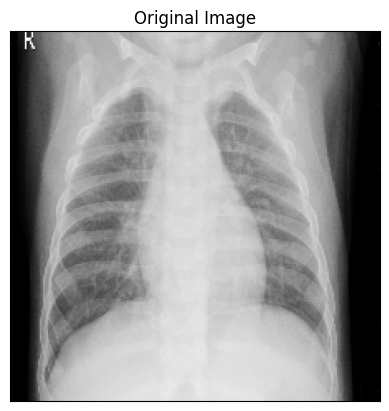

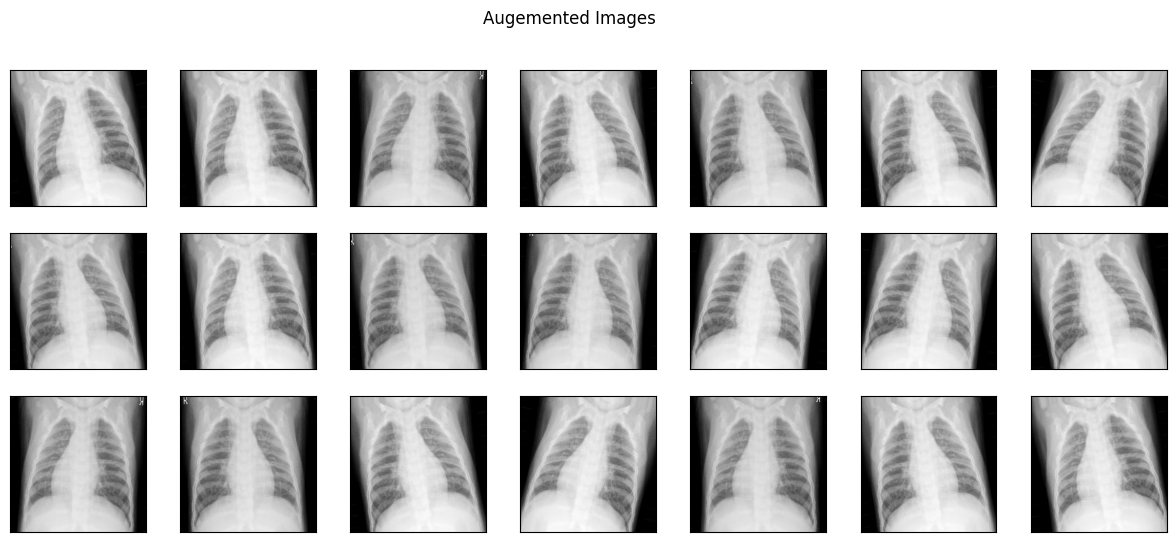

In [19]:
trainAug  = ImageDataGenerator(
    rotation_range=15,

    horizontal_flip=True,
    fill_mode="nearest")

# demo augmentation
# set the paramters we want to change randomly

os.mkdir('preview_1')
x = x_train[1]
x = x.reshape((1,) + x.shape)

i = 0
for batch in trainAug.flow(x, batch_size=1, save_to_dir='preview_1', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 30:
        break

plt.imshow(x_train[1])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_1/'):
    img = cv2.imread('preview_1/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [22]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

In [23]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout(rate=0.3)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,989,955 (11.41 MB)

 Trainable params: 2,955,843 (11.28 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# setting call back function
callbacks = [ModelCheckpoint('.mdl_wts_mobilenetv2.keras', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [25]:
#batch size
BS = 16
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(x_train,y_train, batch_size=BS),
    steps_per_epoch=train_len // BS,
    validation_data=(x_test, y_test),
    validation_steps=test_len // BS,
    epochs=50,callbacks=callbacks)

[INFO] training head...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8128 - loss: 0.7067
Epoch 1: val_loss improved from inf to 3.20668, saving model to .mdl_wts_mobilenetv2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.8132 - loss: 0.7010 - val_accuracy: 0.8552 - val_loss: 3.2067 - learning_rate: 0.0010
Epoch 2/50
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - accuracy: 0.8750 - loss: 0.2330

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 3.20668
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 293ms/step - accuracy: 0.8750 - loss: 0.2330 - val_accuracy: 0.8552 - val_loss: 3.3054 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8655 - loss: 0.2579
Epoch 3: val_loss did not improve from 3.20668

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
36/36 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.8660 - loss: 0.2581 - val_accuracy: 0.8552 - val_loss: 3.2506 - learning_rate: 0.0010
Epoch 4/50
 1/36 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - accuracy: 1.0000 - loss: 0.1925
Epoch 4: val_loss did not improve from 3.20668
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 0.1925 - val_accuracy: 0.8552 - val_loss: 3.2302 - learning_rate: 3.0000e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9236 - loss: 0.2275
Epoch 5: val_loss did not improve from 3.20668

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.

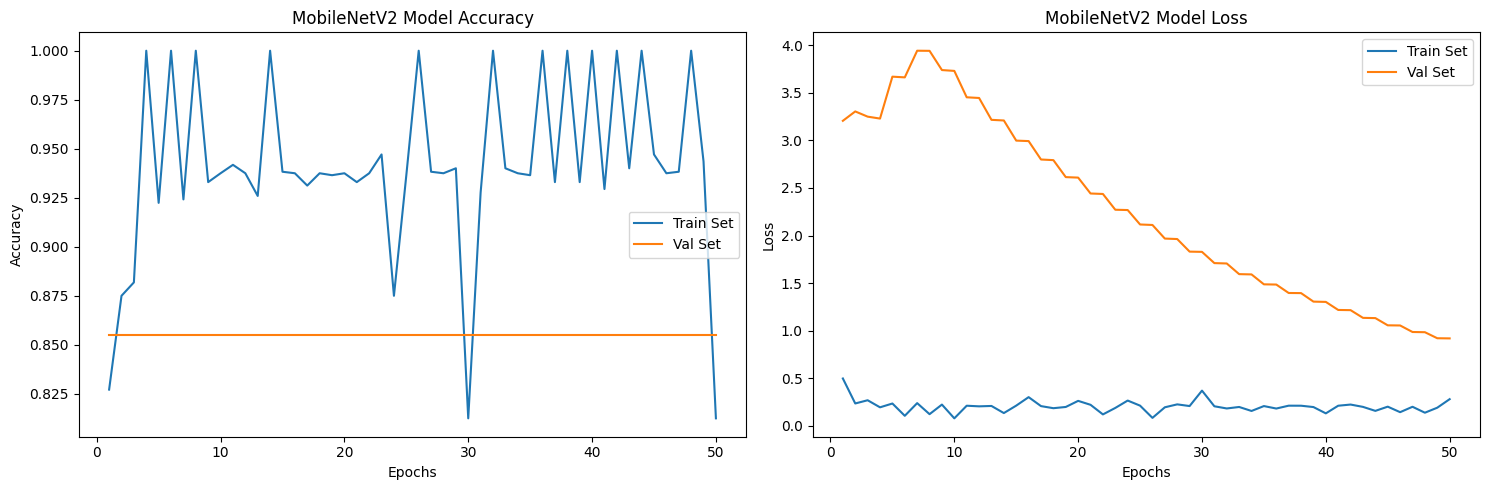

In [26]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs_range = range(1, len(H.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNetV2 Model Loss')

plt.tight_layout()
plt.show()

In [27]:
from tensorflow.keras.models import load_model

model = load_model('.mdl_wts_mobilenetv2.keras')
model.save('/content/drive/My Drive/COVID_IEEE/model_v1.h5')

model = load_model('/content/drive/My Drive/COVID_IEEE/model_v1.h5')
# checking the accuracy
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8927 - loss: 0.7850

 Test_Accuracy:- 0.8551723957061768
